<a href="https://colab.research.google.com/github/LeeYeonGeol/ML_DL_Practice/blob/main/CIFAR10%20%EC%97%B0%EC%8A%B5%20(%EC%82%AC%EC%A0%84%ED%95%99%EC%8A%B5_%EB%AA%A8%EB%8D%B8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG 모델

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
from tensorflow.keras.applications import VGG16, ResNet50, ResNet50V2, Xception

## 데이터 전처리

In [3]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

def set_random_seed(seed_value):
  np.random.seed(seed_value)
  python_random.seed(seed_value)
  tf.random.set_seed(seed_value)

def get_preprocessed_data(images, labels, scaling=True):
  if scaling:
    images = np.array(images/255.0, dtype=np.float32)
  else:
    images = np.array(images, dtype=np.float32)
  
  labels = np.array(labels, dtype=np.float32)

  return images, labels

def get_preprocessed_ohe(images, labels):
  images, labels = get_preprocessed_data(images, labels, scaling=False)

  oh_labels = to_categorical(labels)
  return images, oh_labels

def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
  train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
  test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)

  tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)

  return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels)

set_random_seed(2021)

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) =  \
get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)

print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    horizontal_flip = True,
    rescale = 1/255.0
)

valid_generator = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)

## Keras CNN 모델 생성 함수

In [15]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

def create_model(verbose=False):
  input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
  base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
  bm_output = base_model.output

  x = GlobalAveragePooling2D()(bm_output)
  # x = Dropout(rate=0.5)(x)
  x = Dense(50, activation='relu', name = 'fc1')(x)
  # x = Dropout(rate=0.5)(x)
  output = Dense(10, activation='softmax', name='output')(x)

  model = Model(inputs=input_tensor, outputs= output)
  if verbose:
    model.summary()
  
  return model

In [16]:
vgg_model = create_model(verbose=True)
vgg_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [17]:
history = vgg_model.fit(flow_tr_gen, epochs=40,
                        validation_data=flow_val_gen,
                        callbacks=[rlr_cb, ely_cb])

Epoch 1/40
665/665 [==============================] - 26s 37ms/step - loss: 2.1534 - accuracy: 0.1740 - val_loss: 1.5988 - val_accuracy: 0.3409
Epoch 2/40
665/665 [==============================] - 25s 37ms/step - loss: 1.4721 - accuracy: 0.4175 - val_loss: 1.1206 - val_accuracy: 0.6013
Epoch 3/40
665/665 [==============================] - 25s 37ms/step - loss: 1.0274 - accuracy: 0.6410 - val_loss: 0.8830 - val_accuracy: 0.7004
Epoch 4/40
665/665 [==============================] - 25s 37ms/step - loss: 0.8235 - accuracy: 0.7213 - val_loss: 0.8107 - val_accuracy: 0.7345
Epoch 5/40
665/665 [==============================] - 25s 37ms/step - loss: 0.7292 - accuracy: 0.7564 - val_loss: 0.7349 - val_accuracy: 0.7621
Epoch 6/40
665/665 [==============================] - 25s 37ms/step - loss: 0.6408 - accuracy: 0.7883 - val_loss: 0.6775 - val_accuracy: 0.7807
Epoch 7/40
665/665 [==============================] - 25s 37ms/step - loss: 0.5781 - accuracy: 0.8073 - val_loss: 0.6573 - val_accuracy:

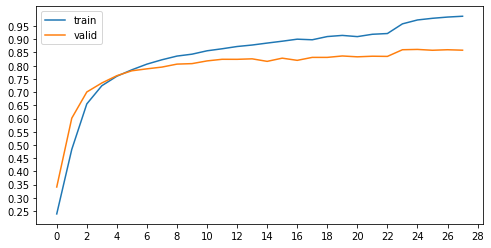

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
  plt.figure(figsize=(8, 4))
  plt.yticks(np.arange(0, 1, 0.05))
  plt.xticks(np.arange(0, 30, 2))
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='valid')
  plt.legend()

show_history(history)

# Xception 모델

## 지금까지의 로직들을 함수화

In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception

def set_random_seed(seed_value):
  np.random.seed(seed_value)
  python_random.seed(seed_value)
  tf.random.set_seed(seed_value)

def get_preprocessed_data(images, labels, scaling=True):
  if scaling:
    images = np.array(images/255.0, dtype=np.float32)
  else:
    images = np.array(images, dtype=np.float32)
  
  labels = np.array(labels, dtype=np.float32)

  return images, labels

def get_preprocessed_ohe(images, labels):
  images, labels = get_preprocessed_data(images, labels, scaling=False)
  oh_labels = to_categorical(labels)

  return images, oh_labels

def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
  train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
  test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)

  tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)

  return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels)

def get_resized_images(images, resize=64):
  image_cnt = images.shape[0]
  resized_images = np.zeros((images.shape[0], resize, resize, 3))
  for i in range(image_cnt):
    resized_image = cv2.resize(images[i], (resize, resize))
    resized_images[i] = resized_image

  return resized_images

def create_model(model_name='vgg16', verbose=False):
  input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
  if model_name == 'vgg16':
    base_model = VGG16(input_tenser=input_tensor, include_top=False, weights='imagesnet')
  elif model_name == 'resnet50':
    base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weighs='imagenet')
  elif model_name == 'xception':
    base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')

  bm_output = base_model.output

  x = GlobalAveragePooling2D()(bm_output)
  if model_name != 'vgg16':
    x = Dropout(rate=0.5)(x)
  x = Dense(50, activation='relu', name='fc1')(x)
  output = Dense(10, activation='softmax', name='output')(x)

  model = Model(inputs=input_tensor, outputs=output)
  model.summary()

  return model

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

def do_cifar10_train_evaluation(image_size=IMAGE_SIZE, model_name='vgg16'):
  set_random_seed(2021)
  (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
  (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
      get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)
  print('데이터 세트 shape:', tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

  if image_size > 32:
    tr_images = get_resized_images(tr_images)
    val_images = get_resized_images(val_images)
    test_images = get_resized_images(test_images)
  
  train_generator = ImageDataGenerator(
      horizontal_flip = True,
      rescale = 1/255.0
  )

  valid_generator = ImageDataGenerator(rescale=1/255.0)
  test_generator = ImageDataGenerator(rescale=1/255.0)

  flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
  flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
  flow_test_gen = train_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE ,shuffle=False)

  model = create_model(model_name=model_name, verbose=True)
  model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

  rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
  ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

  tr_data_len = tr_images.shape[0]
  val_data_len = val_images.shape[0]
  history = model.fit(flow_tr_gen, epochs=40,
                      steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)),
                      validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)),
                      callbacks=[rlr_cb, ely_cb])
  
  evaluation_result = model.evaluate(flow_test_gen)
  print('테스트 데이터 세트 evaluation 결과:', evaluation_result)
  return history, evaluation_result

In [3]:
import gc
gc.collect()

99

In [4]:
history, evaluation_result = do_cifar10_train_evaluation(image_size=64, model_name='xception')

170500096/170498071 [==============================] - 4s 0us/step
데이터 세트 shape: (42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)
83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 15, 15, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 15, 15, 32)   128         block1_conv1[0][0]               
_______________________________________________________

In [5]:
print('테스트 데이터세트 검증결과:', evaluation_result)

테스트 데이터세트 검증결과: [0.364653617143631, 0.9337999820709229]


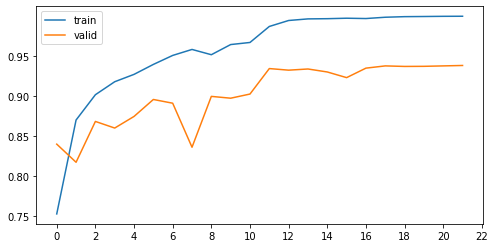

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
  plt.figure(figsize=(8, 4))
  plt.yticks(np.arange(0, 1, 0.05))
  plt.xticks(np.arange(0, 30, 2))
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='valid')
  plt.legend()

show_history(history)